In [1]:
%load_ext autoreload
%autoreload 2
%cd ..


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
%load_ext snakeviz


In [ ]:
import sys
import os

import numpy as np
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

utils.reset_seeds(0)


In [4]:
%pwd

'c:\\Users\\troosma\\Documents\\Ylikool\\6. semester\\Bakatöö\\bakatoo'

In [10]:
def rmse_traindata(X_train, y_train, start, end, fn=lambda x: x**2):
    """Leiab antud piirkonnas asuvate treeningpunktide rmse väärtuse.

    :param X_train: treeningandmed X
    :param y_train: treeningandmed y
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: fn millega y saada, defaults to lambdax:x**2
    :return: rmse
    """

    # ehk kõik need väärtused kus X_train on vahemikus [start, end)
    X = X_train[np.logical_and(X_train >= start, X_train < end)]
    # ehk kõik need indeksid, kus X_train on vahemikus [start, end)
    y = y_train[np.where((X_train >= start) & (X_train < end))[0]]

    return np.sqrt(np.mean((y-fn(X))**2))


In [11]:
def rmse_estimate(model, X_train, start, end, fn=lambda x: x**2):
    """Leiab rmse treeningandmete põhjal, on võimalik anda ka ette vahemik (start, end), kus leitakse see rmse.

    :param model: mudel
    :param X_train: treeningandmed
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: default on x^2
    :return: rmse
    """

    X = X_train[np.logical_and(X_train >= start, X_train < end)]
    num = len(X)

    if num == 0:
        return 0
    assert num > 0, "No data in interval"
    y_pred = model.predict(X, verbose=False)
    variance = np.exp(y_pred[:, 1:])

    return np.sqrt(np.sum(variance)/num)


In [12]:
def rmse_estimate_grid(model, start, end, fn=lambda x: x**2, steps=5000):
    """Leiab gridi läbi käimisel mudeli rmse väärtuse.

    :param model: mudel
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: fn, defaults to lambdax:x**2
    :param steps: gridi peensus, defaults to 5000
    :return: rmse
    """

    X = np.linspace(start, end, steps)
    y = model.predict(X, verbose=False)
    variance = np.exp(y[:, 1:])
    return np.sqrt(np.sum(variance)/steps)


In [13]:
def all_rmses(model, X_train, y_train, start, end, fn=lambda x: x**2, steps=5000):
    """rmse_traindata, rmse_estimate, rmse_estimate_grid mugavusfunk

    :param model: _description_
    :param X_train: _description_
    :param y_train: _description_
    :param start: _description_
    :param end: _description_
    :param fn: _description_, defaults to lambdax:x**2
    :param steps: _description_, defaults to 5000
    :return: _description_
    """
    return rmse_traindata(X_train, y_train, start, end, fn), \
        rmse_estimate(model, X_train, start, end, fn), \
        rmse_estimate_grid(model, start, end, fn, steps)


In [270]:
def all_rmses_better(model, X_train, y_train, start, end, window_length=1, rmse_steps=100, fn=lambda x: x**2, grid_steps=10000):
    """rmse_traindata, rmse_estimate, rmse_estimate_grid mugavusfunk

    :param model: _description_
    :param X_train: _description_
    :param y_train: _description_
    :param start: _description_
    :param end: _description_
    :param fn: _description_, defaults to lambdax:x**2
    :param grid_steps: _description_, defaults to 5000
    :return: _description_
    """

    res = []
    for istart in np.linspace(start, end, rmse_steps):
        # TREENINGAMDETE PÕHJAL
        # ehk kõik need väärtused kus X_train on vahemikus [start, end)

        X = X_train[np.logical_and(
            X_train >= istart, X_train < istart+window_length)]
        # ehk kõik need indeksid, kus X_train on vahemikus [start, end)
        y = y_train[np.where((X_train >= istart) & (
            X_train < istart+window_length))[0]]
        rmse1 = np.sqrt(np.mean((y-fn(X))**2))      #empiiriline müramäär

        # MUDELISSE ANTUD TREENINGANDMETE PÕHJAL
        X = X_train[np.logical_and(
            X_train >= istart, X_train < istart+window_length)]
        num = len(X)
        #assert num > 0, "No data in interval"
        if num != 0:
            y_pred = model.predict(X, verbose=False)
            variance = np.exp(y_pred[:, 1:])
            rmse2 = np.sqrt(np.sum(variance)/num)
        else:
            rmse2 = np.nan  # sus
        res.append([istart, rmse1, rmse2])

    # GRIDI LÄBI KÄIMISEL
    X = np.linspace(start, end, grid_steps)
    y = model.predict(X, verbose=False)
    mean = y[:, 0:1]
    for idx, istart in enumerate(np.linspace(start, end, rmse_steps)):
        temp_mean = mean[np.logical_and(X >= istart, X < istart+window_length)]
        rmse3 = np.sqrt(np.mean((temp_mean-fn(np.logical_and(X >= istart, X < istart+window_length)))**2))
        res[idx].append(rmse3)

    return np.asanyarray(res)
    #rmse3 = np.sqrt(np.sum(variance)/grid_steps)


# all_rmses_better(model, X_train, y_train, start=-2.5, end=12.5, rmse_steps=100, fn=lambda x: x*np.sin(x),window_length=akna_laius)


grid on pmst test
müra määr, tegelik (valemist) & empiriline (vahemikus)
optimaalne rmse andmetel

keskväärtusest saab mudeli_rmse_train ja _test 
dispersioonist saab lõigu keskmise variance **0.5 mse_hinnang

neid saab siis vahemikus 
1. ennustatud keskväärtus - tegelik
2. kaugel on ennustatud keskväärtus - (treening)andmepunktist 
3. kaugel on ennustatud keskväärtus - (test)andmepunktist 
4. kui suur ennustatud standardhälve
5. tegelik müra tase (müra gene valemist)
6. sample (vahemiku) variance 


iga treeningpunktil mõõdetud asi saab ka teha testpunktidel
1. tegelik müra (müratase, müramäär valemist)
2. ennustatud määramatus (müra määr)
3. kaugel on punkt - ennustus keksväärtus
4. fn (tegelik keskv) - ennustus keskv  
5. kaugel on punk - tegelik fn

bias-variance decomposition - kui MSEga vaadata siis tuleb kahe summaks kolmas
roheline hakkab kesketläbi klappima ennustadu määramatus läheb klappima empiirilise määramatusega (2.,3.)
2 peab alati > kui 1
1.+4. = 3. (treeningandmetel)

TODO: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff 
TODO: bias–variance decomposition
kuidas 2 käitub??

1 aleaotooriline
3-4 tegelikud vead
kuidas 2 aitab ennustada 3-4

6. punkt - tegelik (empiiriline müra)
7. kahte variance vaadata

In [15]:
def joonista_variance(m: tf.keras.Sequential, X_test, X_train, y_train=None, bpoint_fn=Slopes.breakpoint_finder, *, ground_truth=False, xlim=None, ylim=None, returnplt=False, no_variance=False):

    bpoints = bpoint_fn(m, X_test)

    _patterns = [bp[1] for bp in bpoints]
    bpoints = [bp[0] for bp in bpoints]

    start, end = xlim if xlim else (-1, 1)

    print(f"model contains {len(bpoints)} breaks")

    y_pred = m.predict(X_test)

    if no_variance:
        y_pred_mean = y_pred
    else:
        y_pred_mean, y_pred_logvar = y_pred[:, 0], y_pred[:, 1]
        y_pred_var = np.exp(y_pred_logvar)
        y_pred_sd = np.sqrt(y_pred_var)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # absoluutselt õige
    if ground_truth:
        plt.plot(np.linspace(start, end, 1000), ground_truth(np.linspace(
            start, end, 1000)), label="ground truth", alpha=0.5, color="yellow")

    plt.plot(X_test, y_pred_mean, label="mean")
    if not no_variance:
        plt.fill_between(X_test, y_pred_mean - 1.96*y_pred_sd,
                         y_pred_mean + 1.96*y_pred_sd, alpha=0.2, label="2 standard hälvet")
    plt.scatter(X_train, y_train, marker='.', color="red", label="train")

    temp_bpoints = list(zip(*bpoints))
    bx, by = temp_bpoints[0], temp_bpoints[1]

    plt.scatter(bx, by, marker="o", color="green", label="breaks")

    plt.legend()

    if returnplt:
        return plt

    plt.show()


In [16]:
# y = x · sin(x) + 0.3 · e_1 + 0.3 · x · e_2, with e_1, e_2 ∼ N (0, 1)

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_truth = np.linspace(-4, 14, 2000)
ground_truth = X_truth * np.sin(X_truth)


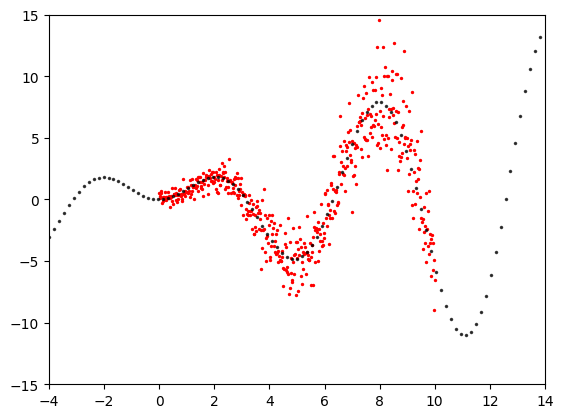

In [17]:
plt.plot(X_truth, ground_truth, marker='.', markersize=3, markevery=20, alpha=0.7,
         linewidth=0, color='black', label='ground truth')
plt.scatter(X, y, s=2, color='red')
plt.xlim(-4, 14)
plt.ylim(-15, 15)
plt.show()


In [71]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='relu', name="layer_1"),
    layers.Dense(units=50, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)


Epoch:   0 | Loss: 3.40168e+01
Epoch: 100 | Loss: 3.44522e+00
Epoch: 200 | Loss: 3.26825e+00
Epoch: 300 | Loss: 3.20768e+00
Epoch: 400 | Loss: 3.15582e+00
Epoch: 500 | Loss: 3.11948e+00
Epoch: 600 | Loss: 3.09000e+00
Epoch: 700 | Loss: 3.06234e+00
Epoch: 800 | Loss: 3.03725e+00
Epoch: 900 | Loss: 3.01571e+00
Epoch: 1000 | Loss: 2.99735e+00
Epoch: 1100 | Loss: 2.98042e+00
Epoch: 1200 | Loss: 2.96332e+00
Epoch: 1300 | Loss: 2.94754e+00
Epoch: 1400 | Loss: 2.93247e+00
Epoch: 1500 | Loss: 2.91874e+00
Epoch: 1600 | Loss: 2.90580e+00
Epoch: 1700 | Loss: 2.89403e+00
Epoch: 1800 | Loss: 2.88314e+00
Epoch: 1900 | Loss: 2.87381e+00


63/63 [==============================] - 0s 3ms/step
model contains 56 breaks
63/63 [==============================] - 0s 2ms/step


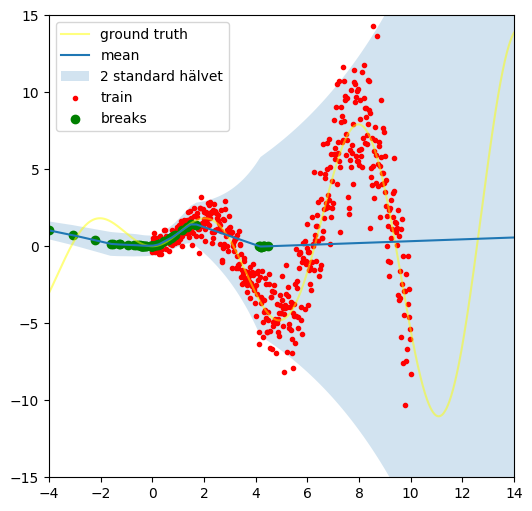

In [72]:
joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


## 50-50 sigmoidid, ainult mean


Epoch:   0 | Loss: 1.77210e+01
Epoch: 100 | Loss: 3.35144e+00
Epoch: 200 | Loss: 3.44625e+00
Epoch: 300 | Loss: 3.18159e+00
Epoch: 400 | Loss: 3.17531e+00
Epoch: 500 | Loss: 3.19520e+00
Epoch: 600 | Loss: 3.10797e+00
Epoch: 700 | Loss: 3.16928e+00
Epoch: 800 | Loss: 3.38130e+00
Epoch: 900 | Loss: 3.17561e+00
Epoch: 1000 | Loss: 3.17002e+00
Epoch: 1100 | Loss: 3.60615e+00
Epoch: 1200 | Loss: 3.23950e+00
Epoch: 1300 | Loss: 3.23547e+00
Epoch: 1400 | Loss: 3.37909e+00
Epoch: 1500 | Loss: 3.38807e+00
Epoch: 1600 | Loss: 3.04328e+00
Epoch: 1700 | Loss: 3.16764e+00
Epoch: 1800 | Loss: 3.36330e+00
Epoch: 1900 | Loss: 3.14974e+00
63/63 [==============================] - 0s 3ms/step
model contains 2 breaks
63/63 [==============================] - 0s 3ms/step


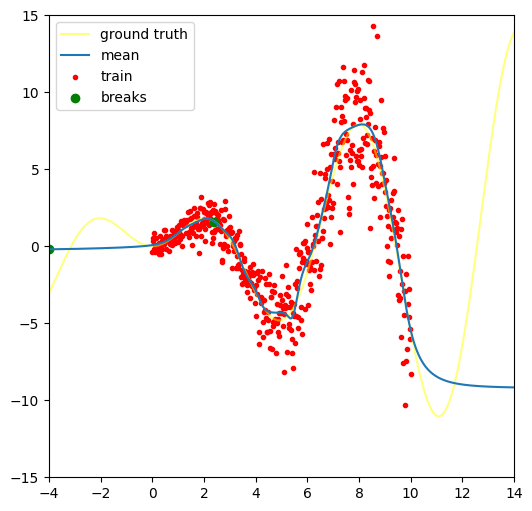

In [80]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='sigmoid', name="layer_1"),
    layers.Dense(units=50, activation='sigmoid', name="layer_2"),
    layers.Dense(units=1, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss='MSE',
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x), no_variance=True)


## 50-50 sigmoid mean&variance


Epoch:   0 | Loss: 7.80733e+00
Epoch: 100 | Loss: 1.96975e+00
Epoch: 200 | Loss: 1.75411e+00
Epoch: 300 | Loss: 1.63436e+00
Epoch: 400 | Loss: 1.56967e+00
Epoch: 500 | Loss: 1.57814e+00
Epoch: 600 | Loss: 1.55904e+00
Epoch: 700 | Loss: 1.58511e+00
Epoch: 800 | Loss: 1.58552e+00
Epoch: 900 | Loss: 1.55888e+00
Epoch: 1000 | Loss: 1.58924e+00
Epoch: 1100 | Loss: 1.62211e+00
Epoch: 1200 | Loss: 1.56640e+00
Epoch: 1300 | Loss: 1.58053e+00
Epoch: 1400 | Loss: 1.57549e+00
Epoch: 1500 | Loss: 1.57017e+00
Epoch: 1600 | Loss: 1.53946e+00
Epoch: 1700 | Loss: 1.55617e+00
Epoch: 1800 | Loss: 1.61313e+00
Epoch: 1900 | Loss: 1.54855e+00
63/63 [==============================] - 0s 3ms/step
model contains 1 breaks
63/63 [==============================] - 0s 2ms/step


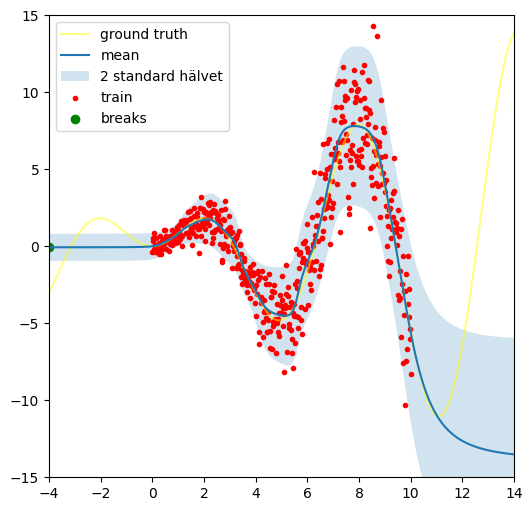

In [81]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='sigmoid', name="layer_1"),
    layers.Dense(units=50, activation='sigmoid', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


## 50-50 relu, mean&variance


Epoch:   0 | Loss: 8.59768e+00
Epoch: 100 | Loss: 2.27685e+00
Epoch: 200 | Loss: 2.15734e+00
Epoch: 300 | Loss: 2.14472e+00
Epoch: 400 | Loss: 2.07543e+00
Epoch: 500 | Loss: 1.99187e+00
Epoch: 600 | Loss: 1.96075e+00
Epoch: 700 | Loss: 1.81819e+00
Epoch: 800 | Loss: 1.72861e+00
Epoch: 900 | Loss: 1.63508e+00
Epoch: 1000 | Loss: 1.63123e+00
Epoch: 1100 | Loss: 1.59800e+00
Epoch: 1200 | Loss: 1.58661e+00
Epoch: 1300 | Loss: 1.62511e+00
Epoch: 1400 | Loss: 1.61476e+00
Epoch: 1500 | Loss: 1.58501e+00
Epoch: 1600 | Loss: 1.54701e+00
Epoch: 1700 | Loss: 1.58001e+00
Epoch: 1800 | Loss: 1.62040e+00
Epoch: 1900 | Loss: 1.57794e+00
63/63 [==============================] - 0s 2ms/step
model contains 55 breaks
63/63 [==============================] - 0s 1ms/step


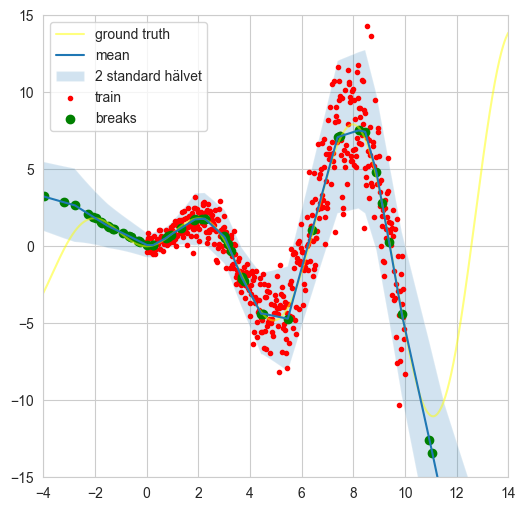

In [145]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='relu', name="layer_1"),
    layers.Dense(units=50, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


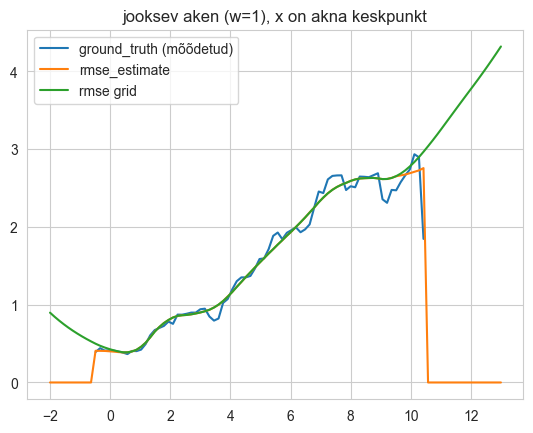

In [146]:
# Vana viis sama asja arvutada
akna_laius = 1
starts = []
ends = []
rmse_traindatas = []
rmse_estimates = []
rmse_estimate_grids = []

for start in np.linspace(-2.5, 12.5, 100):
    alls = all_rmses(model, X_train, y_train, start=start,
                     end=start+akna_laius, fn=lambda x: x*np.sin(x), steps=5000)
    starts.append(start)
    ends.append(start+akna_laius)
    rmse_traindatas.append(alls[0])
    rmse_estimates.append(alls[1])
    rmse_estimate_grids.append(alls[2])


starts = np.array(starts)
# rmse_traindata,rmse_estimate,rmse_estimate_grid
plt.plot(starts+akna_laius/2, rmse_traindatas, label='ground_truth (mõõdetud)')
plt.plot(starts+akna_laius/2, rmse_estimates, label='rmse_estimate')
plt.plot(starts+akna_laius/2, rmse_estimate_grids, label='rmse grid')
plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\2260604561.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


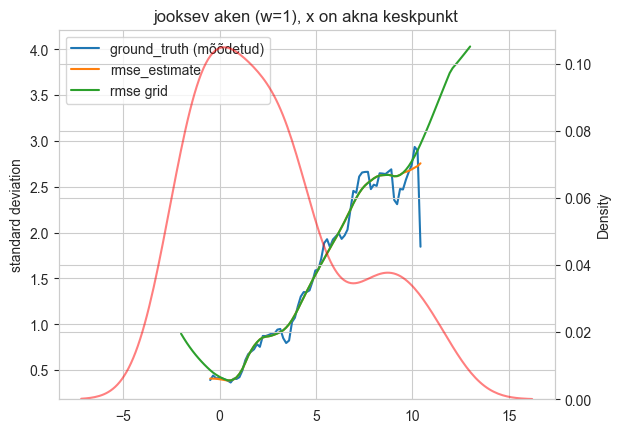

In [147]:
# Uus ja parem


akna_laius = 1

rmses = all_rmses_better(model, X_train, y_train, start=-2.5, end=12.5,
                         rmse_steps=100, fn=lambda x: x*np.sin(x), window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('whitegrid')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())


plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


## Reverse noise (50-50 relu)


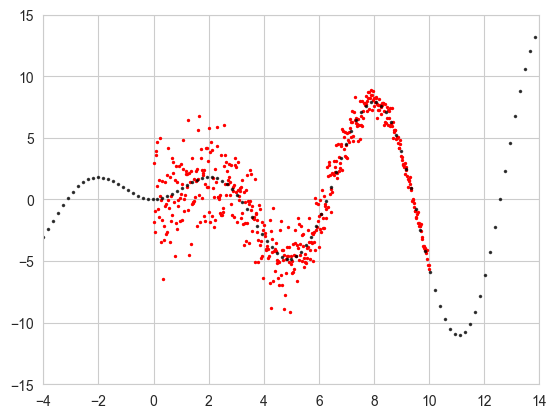

In [148]:
# y = x · sin(x) + 0.3 · e_1 + 0.3 · x · e_2, with e_1, e_2 ∼ N (0, 1)

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + \
    0.3 * X[::-1] * np.random.randn(500)

X_truth = np.linspace(-4, 14, 2000)
ground_truth = X_truth * np.sin(X_truth)


plt.plot(X_truth, ground_truth, marker='.', markersize=3, markevery=20, alpha=0.7,
         linewidth=0, color='black', label='ground truth')
plt.scatter(X, y, s=2, color='red')
plt.xlim(-4, 14)
plt.ylim(-15, 15)
plt.show()


Epoch:   0 | Loss: 8.94506e+00
Epoch: 100 | Loss: 2.66289e+00
Epoch: 200 | Loss: 1.88467e+00
Epoch: 300 | Loss: 1.84152e+00
Epoch: 400 | Loss: 1.75504e+00
Epoch: 500 | Loss: 2.05116e+00
Epoch: 600 | Loss: 1.76704e+00
Epoch: 700 | Loss: 1.74271e+00
Epoch: 800 | Loss: 1.72710e+00
Epoch: 900 | Loss: 1.69755e+00
Epoch: 1000 | Loss: 1.71409e+00
Epoch: 1100 | Loss: 1.77045e+00
Epoch: 1200 | Loss: 1.76877e+00
Epoch: 1300 | Loss: 1.66305e+00
Epoch: 1400 | Loss: 1.84560e+00
Epoch: 1500 | Loss: 1.72179e+00
Epoch: 1600 | Loss: 1.80551e+00
Epoch: 1700 | Loss: 1.70346e+00
Epoch: 1800 | Loss: 1.70795e+00
Epoch: 1900 | Loss: 1.75036e+00
63/63 [==============================] - 0s 3ms/step
model contains 47 breaks
63/63 [==============================] - 0s 3ms/step


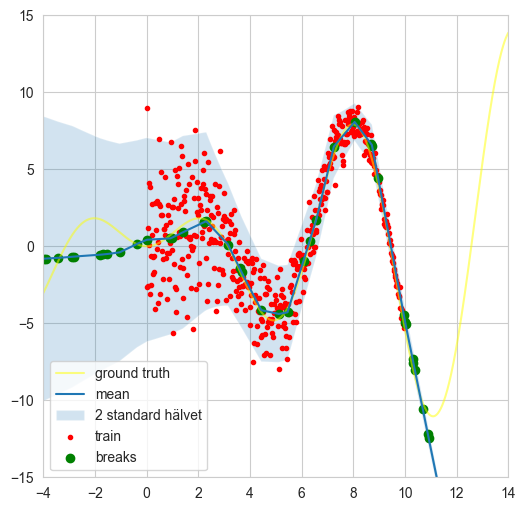

In [149]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='relu', name="layer_1"),
    layers.Dense(units=50, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + \
    0.3 * X[::-1] * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


313/313 [==============================] - 1s 2ms/step


C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\1050154717.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


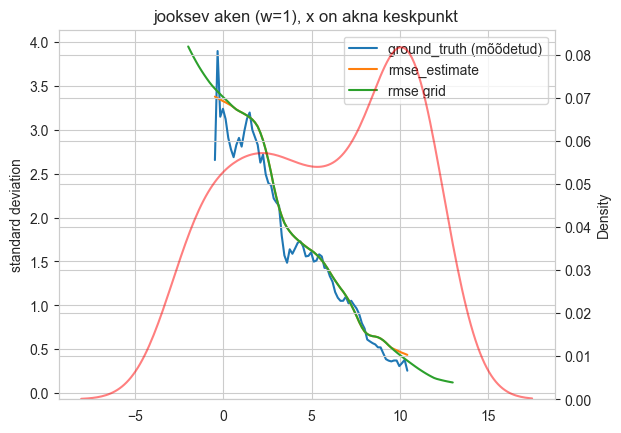

In [150]:
# Uus ja parem

akna_laius = 1

rmses = all_rmses_better(model, X_train, y_train, start=-2.5, end=12.5,
                         rmse_steps=100, fn=lambda x: x*np.sin(x), window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('whitegrid')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())


plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


## Vähem relusid (10-10)


Epoch:   0 | Loss: 3.42165e+00
Epoch: 100 | Loss: 3.10433e+00
Epoch: 200 | Loss: 3.10069e+00
Epoch: 300 | Loss: 3.09556e+00
Epoch: 400 | Loss: 2.91834e+00
Epoch: 500 | Loss: 2.83389e+00
Epoch: 600 | Loss: 2.75475e+00
Epoch: 700 | Loss: 2.63135e+00
Epoch: 800 | Loss: 2.33391e+00
Epoch: 900 | Loss: 2.11482e+00
Epoch: 1000 | Loss: 2.07490e+00
Epoch: 1100 | Loss: 2.03084e+00
Epoch: 1200 | Loss: 2.00429e+00
Epoch: 1300 | Loss: 1.98359e+00
Epoch: 1400 | Loss: 1.99780e+00
Epoch: 1500 | Loss: 1.97304e+00
Epoch: 1600 | Loss: 1.95478e+00
Epoch: 1700 | Loss: 1.94612e+00
Epoch: 1800 | Loss: 1.94545e+00
Epoch: 1900 | Loss: 1.92457e+00
Epoch: 2000 | Loss: 1.94727e+00
Epoch: 2100 | Loss: 1.93111e+00
Epoch: 2200 | Loss: 1.91422e+00
Epoch: 2300 | Loss: 1.91128e+00
Epoch: 2400 | Loss: 1.92998e+00
Epoch: 2500 | Loss: 1.90158e+00
Epoch: 2600 | Loss: 1.90240e+00
Epoch: 2700 | Loss: 1.89117e+00
Epoch: 2800 | Loss: 1.86291e+00
Epoch: 2900 | Loss: 1.92368e+00
Epoch: 3000 | Loss: 1.85631e+00
Epoch: 3100 | Loss

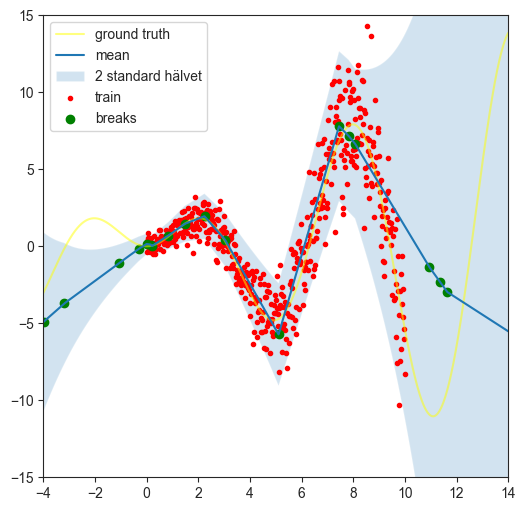

In [169]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=10, activation='relu', name="layer_1"),
    layers.Dense(units=10, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.005, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=4000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\3935642314.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


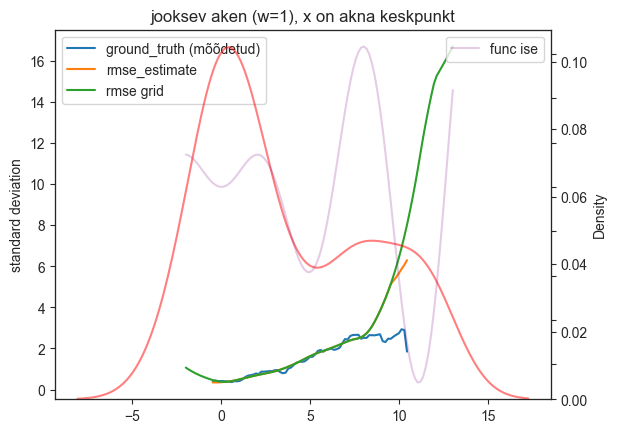

In [170]:
# Uus ja parem

akna_laius = 1

rmses = all_rmses_better(model, X_train, y_train, start=-2.5, end=12.5,
                         rmse_steps=100, fn=lambda x: x*np.sin(x), window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
def fn(x): return x*np.sin(x)


sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


## 10-10 relu, funciks: 2 cos(x) + x


Epoch:   0 | Loss: 3.74304e+00
Epoch: 100 | Loss: 1.79976e+00
Epoch: 200 | Loss: 1.65358e+00
Epoch: 300 | Loss: 1.61557e+00
Epoch: 400 | Loss: 1.59046e+00
Epoch: 500 | Loss: 1.58022e+00
Epoch: 600 | Loss: 1.58212e+00
Epoch: 700 | Loss: 1.59545e+00
Epoch: 800 | Loss: 1.58777e+00
Epoch: 900 | Loss: 1.56561e+00
Epoch: 1000 | Loss: 1.56988e+00
Epoch: 1100 | Loss: 1.58106e+00
Epoch: 1200 | Loss: 1.59026e+00
Epoch: 1300 | Loss: 1.59308e+00
Epoch: 1400 | Loss: 1.59931e+00
Epoch: 1500 | Loss: 1.56725e+00
Epoch: 1600 | Loss: 1.56683e+00
Epoch: 1700 | Loss: 1.58232e+00
Epoch: 1800 | Loss: 1.56418e+00
Epoch: 1900 | Loss: 1.56072e+00
model contains 17 breaks
63/63 [==============================] - 0s 3ms/step


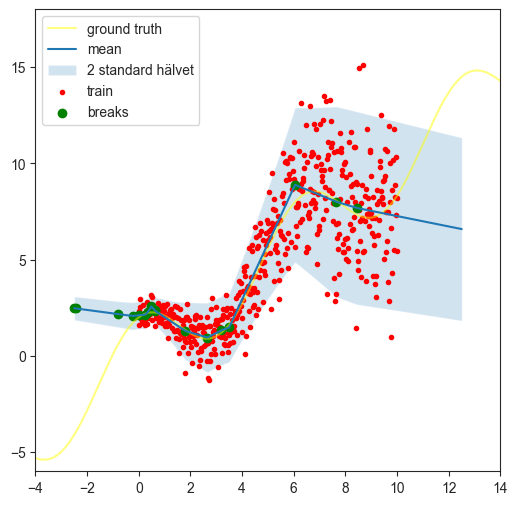

In [242]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=10, activation='relu', name="layer_1"),
    layers.Dense(units=10, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)


def fn(x): return 2*np.cos(x)+x


y = fn(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train,
                  xlim=(-4, 14), ylim=(-6, 18), ground_truth=fn)


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\3001197720.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(


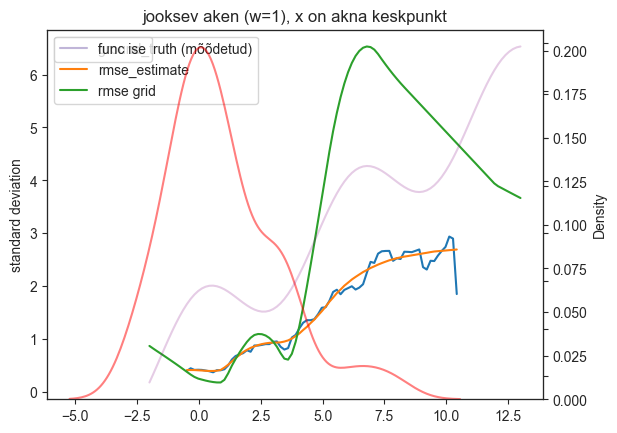

In [271]:
# Uus ja parem

akna_laius = 1
def fn(x): return 2*np.cos(x)+x


X_test = np.linspace(-2.5, 12.5, 10000)
y_test = fn(X_test) + 0.3 * np.random.randn(10000) + \
    0.3 * X_test * np.random.randn(10000)

rmses = all_rmses_better(model, X_train, y_train, start=-2.5,
                         end=12.5, rmse_steps=100, fn=fn, window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


In [269]:
start=-2.5
end=12.5
rmse_steps=100
grid_steps=1000
window_length=1
X = np.linspace(start, end, grid_steps)
y = model.predict(X, verbose=False)
mean = y[:, 0:1]
for idx, istart in enumerate(np.linspace(start, end, rmse_steps)):
    temp_mean = mean[np.logical_and(X >= istart, X < istart+window_length)]
    rmse3 = np.sqrt(np.mean((temp_mean-fn(np.logical_and(X >= istart, X < istart+window_length)))**2))
    print(rmse3)

0.8656791
0.81437355
0.76683724
0.7201094
0.67292696
0.6226677
0.5744525
0.5257894
0.47632575
0.42558947
0.37378612
0.32389706
0.27660307
0.24518809
0.22625466
0.20847933
0.19195113
0.18006368
0.17260692
0.17296694
0.22337309
0.34299237
0.48842084
0.61942506
0.7345352
0.84104687
0.9383785
1.0201615
1.0714483
1.089522
1.0856522
1.0611035
1.0159467
0.94891554
0.8481318
0.7252326
0.62286043
0.6001299
0.72294337
0.9469792
1.2439303
1.5938846
1.9800254
2.3849792
2.8005972
3.2407558
3.6677454
4.097536
4.527752
4.9375267
5.2774463
5.5738316
5.828853
6.0434375
6.2175803
6.350838
6.452741
6.511842
6.5356336
6.5242906
6.472647
6.3890157
6.2893314
6.192719
6.09973
6.0104246
5.9248586
5.8389378
5.7613535
5.686212
5.6111016
5.532212
5.4571037
5.3819966
5.30689
5.2317843
5.1566787
5.07784
5.0027356
4.927633
4.8525305
4.7774296
4.6985598
4.623462
4.5483656
4.4732704
4.398177
4.3230844
4.247994
4.1691566
4.0940676
4.0189805
3.943895
3.8876042
3.8501866
3.81288
3.7756865
3.7386096
3.7016532
3.6648197


### Sama, aga reverse noise


Epoch:   0 | Loss: 4.83954e+00
Epoch: 100 | Loss: 1.74905e+00
Epoch: 200 | Loss: 1.69101e+00
Epoch: 300 | Loss: 1.66739e+00
Epoch: 400 | Loss: 1.67657e+00
Epoch: 500 | Loss: 1.69338e+00
Epoch: 600 | Loss: 1.68554e+00
Epoch: 700 | Loss: 1.67934e+00
Epoch: 800 | Loss: 1.66763e+00
Epoch: 900 | Loss: 1.65180e+00
Epoch: 1000 | Loss: 1.64396e+00
Epoch: 1100 | Loss: 1.65208e+00
Epoch: 1200 | Loss: 1.64678e+00
Epoch: 1300 | Loss: 1.65225e+00
Epoch: 1400 | Loss: 1.62904e+00
Epoch: 1500 | Loss: 1.64168e+00
Epoch: 1600 | Loss: 1.64219e+00
Epoch: 1700 | Loss: 1.67201e+00
Epoch: 1800 | Loss: 1.65366e+00
Epoch: 1900 | Loss: 1.63953e+00
model contains 11 breaks
63/63 [==============================] - 0s 2ms/step


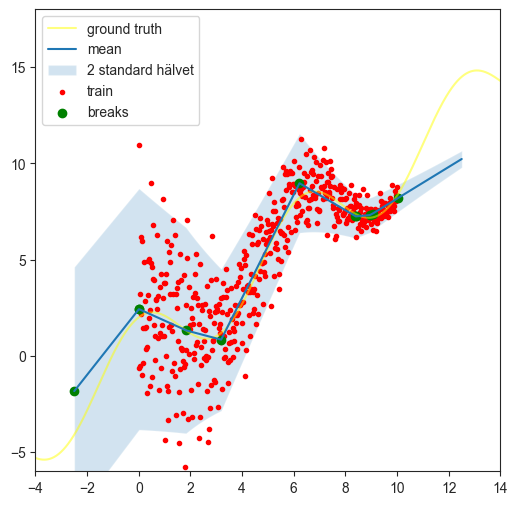

In [245]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=10, activation='relu', name="layer_1"),
    layers.Dense(units=10, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)


def fn(x): return 2*np.cos(x)+x


y = fn(X) + 0.3 * np.random.randn(500) + 0.3 * X[::-1] * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train,
                  xlim=(-4, 14), ylim=(-6, 18), ground_truth=fn)


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\796297080.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


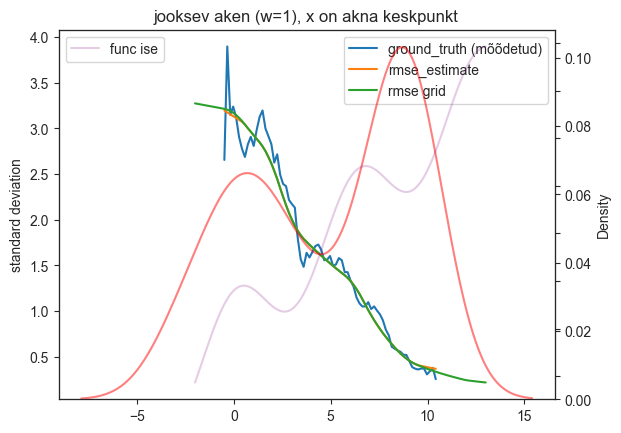

In [246]:
# Uus ja parem

akna_laius = 1
def fn(x): return 2*np.cos(x)+x


rmses = all_rmses_better(model, X_train, y_train, start=-2.5,
                         end=12.5, rmse_steps=100, fn=fn, window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


## 50-50 reluga 2cos(x)+x


Epoch:   0 | Loss: 8.20300e+00
Epoch: 100 | Loss: 1.72527e+00
Epoch: 200 | Loss: 1.59137e+00
Epoch: 300 | Loss: 1.60049e+00
Epoch: 400 | Loss: 1.59666e+00
Epoch: 500 | Loss: 1.57596e+00
Epoch: 600 | Loss: 1.56954e+00
Epoch: 700 | Loss: 1.57500e+00
Epoch: 800 | Loss: 1.59887e+00
Epoch: 900 | Loss: 1.57626e+00
Epoch: 1000 | Loss: 1.57794e+00
Epoch: 1100 | Loss: 1.57453e+00
Epoch: 1200 | Loss: 1.56807e+00
Epoch: 1300 | Loss: 1.57179e+00
Epoch: 1400 | Loss: 1.61478e+00
Epoch: 1500 | Loss: 1.57625e+00
Epoch: 1600 | Loss: 1.55755e+00
Epoch: 1700 | Loss: 1.60583e+00
Epoch: 1800 | Loss: 1.56254e+00
Epoch: 1900 | Loss: 1.56433e+00
model contains 44 breaks
63/63 [==============================] - 0s 2ms/step


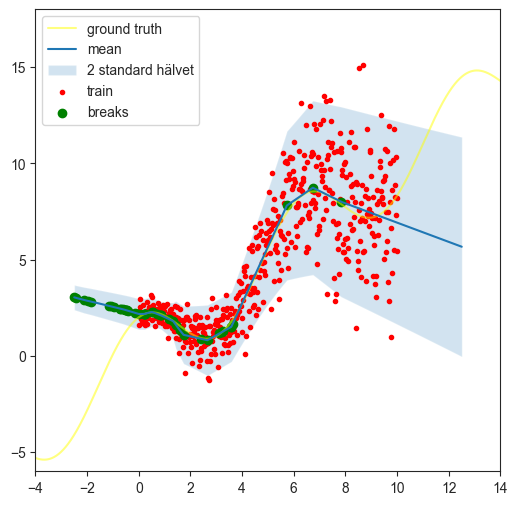

In [254]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='relu', name="layer_1"),
    layers.Dense(units=50, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)


def fn(x): return 2*np.cos(x)+x


y = fn(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train,
                  xlim=(-4, 14), ylim=(-6, 18), ground_truth=fn)


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\796297080.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


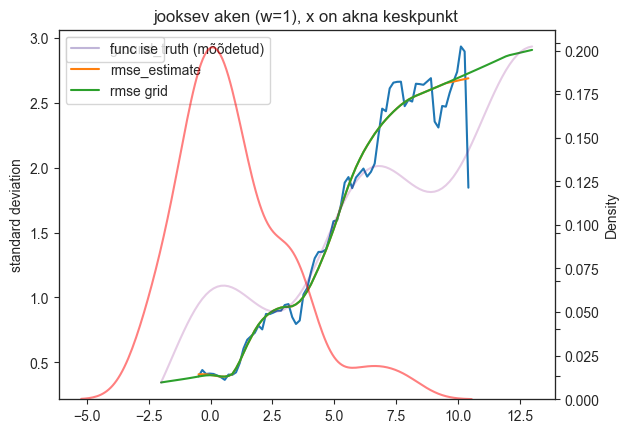

In [255]:
# Uus ja parem

akna_laius = 1
def fn(x): return 2*np.cos(x)+x


rmses = all_rmses_better(model, X_train, y_train, start=-2.5,
                         end=12.5, rmse_steps=100, fn=fn, window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


### Reverse noise


Epoch:   0 | Loss: 9.26270e+00
Epoch: 100 | Loss: 1.78166e+00
Epoch: 200 | Loss: 1.68705e+00
Epoch: 300 | Loss: 1.66463e+00
Epoch: 400 | Loss: 1.64246e+00
Epoch: 500 | Loss: 1.68002e+00
Epoch: 600 | Loss: 1.68504e+00
Epoch: 700 | Loss: 1.62036e+00
Epoch: 800 | Loss: 1.64566e+00
Epoch: 900 | Loss: 1.58755e+00
Epoch: 1000 | Loss: 1.60248e+00
Epoch: 1100 | Loss: 1.61755e+00
Epoch: 1200 | Loss: 1.58341e+00
Epoch: 1300 | Loss: 1.59823e+00
Epoch: 1400 | Loss: 1.59780e+00
Epoch: 1500 | Loss: 1.59635e+00
Epoch: 1600 | Loss: 1.59721e+00
Epoch: 1700 | Loss: 1.60957e+00
Epoch: 1800 | Loss: 1.58399e+00
Epoch: 1900 | Loss: 1.58491e+00
model contains 45 breaks
63/63 [==============================] - 0s 2ms/step


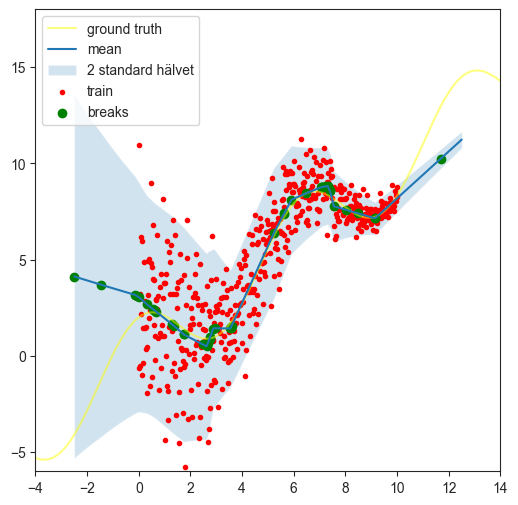

In [250]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=50, activation='relu', name="layer_1"),
    layers.Dense(units=50, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)


def fn(x): return 2*np.cos(x)+x


y = fn(X) + 0.3 * np.random.randn(500) + 0.3 * X[::-1] * np.random.randn(500)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.01, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train,
                  xlim=(-4, 14), ylim=(-6, 18), ground_truth=fn)


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\796297080.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


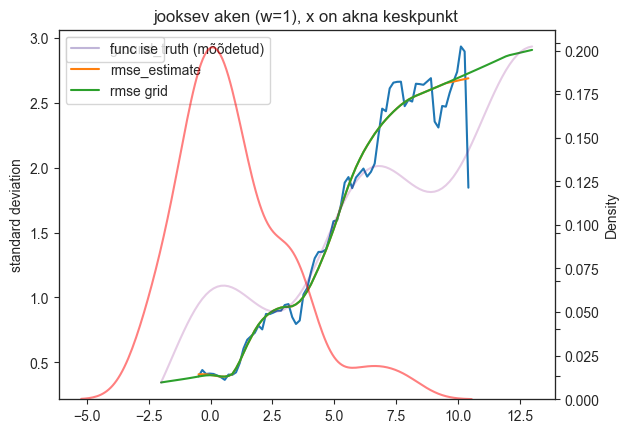

In [257]:
# Uus ja parem

akna_laius = 1
def fn(x): return 2*np.cos(x)+x


rmses = all_rmses_better(model, X_train, y_train, start=-2.5,
                         end=12.5, rmse_steps=100, fn=fn, window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_method=0.4, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\troosma\AppData\Local\Temp\ipykernel_35184\1472324603.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bpoints = np.asanyarray(Slopes.breakpoint_finder(model, np.linspace(-2.5, 12.5, 10000)))


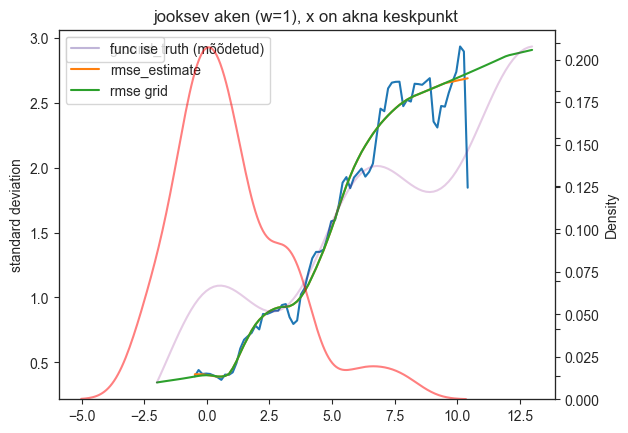

In [259]:
# Uus ja parem

akna_laius = 1
def fn(x): return 2*np.cos(x)+x


rmses = all_rmses_better(model, X_train, y_train, start=-2.5,
                         end=12.5, rmse_steps=100, fn=fn, window_length=akna_laius)
bpoints = np.asanyarray(Slopes.breakpoint_finder(
    model, np.linspace(-2.5, 12.5, 10000)))
x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1],
             label='ground_truth (mõõdetud)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='rmse_estimate')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='rmse grid')
ax.legend()
ax.set_ylabel('standard deviation')

sns.kdeplot(x_coord, bw_adjust=0.8, color='red',
            alpha=0.5, label='breakpoints', ax=ax.twinx())

ax_ground_truth = ax.twinx()
ax_ground_truth.set(yticklabels=[])
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
             alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()


## Debugimise näide


In [1]:
% % prun - s cumulative - D ./tmp/tmp.prof - q
# %%snakeviz
# from cProfile import Profile

# profiler = Profile()
# profiler.enable()


akna_laius = 1
starts = []
ends = []
rmse_traindatas = []
rmse_estimates = []
rmse_estimate_grids = []

for start in np.linspace(-2.5, 12.5, 100):
    alls = all_rmses(model, X_train, y_train, start=start,
                     end=start+akna_laius, fn=lambda x: x*np.sin(x), steps=5000)
    starts.append(start)
    ends.append(start+akna_laius)
    rmse_traindatas.append(alls[0])
    rmse_estimates.append(alls[1])
    rmse_estimate_grids.append(alls[2])


starts = np.array(starts)
# rmse_traindata,rmse_estimate,rmse_estimate_grid
plt.plot(starts+akna_laius/2, rmse_traindatas, label='ground_truth (mõõdetud)')
plt.plot(starts+akna_laius/2, rmse_estimates, label='rmse_estimate')
plt.plot(starts+akna_laius/2, rmse_estimate_grids, label='rmse grid')
plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.legend()
plt.show()

# profiler.disable()
# profiler.print_stats(sort='cumtime')
# profiler.dump_stats('profile.prof')


NameError: name 'np' is not defined

In [224]:
1.7/4


0.425

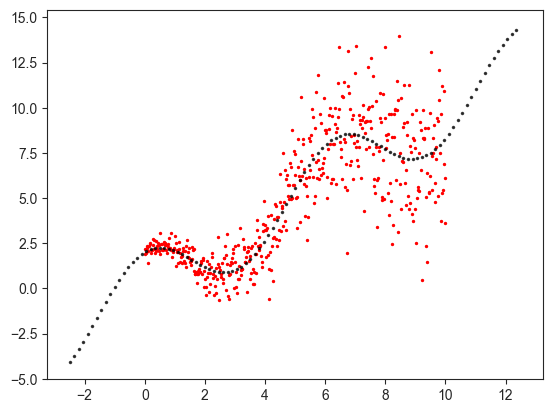

In [239]:
X = np.linspace(0, 10, 500)


def fn(x): return 2*np.cos(x) + x


y = fn(X) + 0.3 * X * np.random.randn(500) + 0.3 * np.random.randn(500)

X_truth = np.linspace(-2.5, 12.5, 2000)
ground_truth = fn(X_truth)


plt.plot(X_truth, ground_truth, marker='.', markersize=3, markevery=20, alpha=0.7,
         linewidth=0, color='black', label='ground truth')
plt.scatter(X, y, s=2, color='red')
#plt.xlim(-4, 14)
#plt.ylim(-15, 15)
plt.show()
